# Counting words and phrases

I've harvested [a gigabyte of OCRd text](https://glam-workbench.github.io/trove-books/#ocrd-text-from-trove-books-and-ephemera) from Trove's digitised books and shared it through Cloudstor. Here we'll explore [*Australian Plain Cookery by a Practical Cook*](https://nla.gov.au/nla.obj-579917051) from 1882. However, you could change the `text_file` value below to point to any of the other books on Cloudstor. There's a complete list [in this CSV file](https://github.com/GLAM-Workbench/trove-books/blob/master/trove_digitised_books_with_ocr.csv).

In [ ]:
import requests
from textblob import TextBlob
import re
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [2]:
CLOUDSTOR_URL = 'https://cloudstor.aarnet.edu.au/plus/s/ugiw3gdijSKaoTL'
text_file = 'australian-plain-cookery-by-a-practical-cook-nla.obj-579917051.txt'
stop_words = stopwords.words('english')

In [3]:
# Get the text file from Cloudstor
response = requests.get(f'{CLOUDSTOR_URL}/download?files={text_file}')
text = response.text

## Counting words

One way of getting a sense of what a piece of text is about is to look at the frequencies with which words appear. You don't need any special software to do basic word counts. You can just split the text into individual words (called tokens) using a regular expression – in the case below, `\w+` looks for groups of alphanumeric characters, separating words from punctuation and spaces. The you can use `Counter` to find the frequency of each word and `.most_common()` to rank them.

In [4]:
words = re.findall(r'\w+', text.lower())
Counter(words).most_common(10)

[('the', 3118),
 ('and', 2826),
 ('a', 2588),
 ('of', 2351),
 ('to', 1171),
 ('in', 1148),
 ('with', 1052),
 ('it', 824),
 ('for', 640),
 ('or', 531)]

<div class="alert alert-info">Try changing the number in the brackets of <code>.most_common()</code>. When you've finished reemember to run the cell again using <b>Shift+Enter</b>!</div>

No suprise that the most common words are things like 'the' and 'of'. To try and focus on words that are distinctive of this particular text we can filter our list of words to remove the most common words in English – we call these 'stopwords'. In the cells above we imported a list of stopwords from the NLTK package. Here we'll drop any words that appear in the stopwords and recount.

In [7]:
filtered_words = [w for w in words if w not in stop_words]
Counter(filtered_words).most_common(10)

[('water', 354),
 ('half', 351),
 ('two', 317),
 ('boil', 298),
 ('butter', 273),
 ('well', 260),
 ('pound', 249),
 ('salt', 244),
 ('little', 243),
 ('add', 241)]

That looks a bit more interesting.

## Displaying a word cloud

Word clouds are a familiar way of visualising word frequencies in a text. The Wordcloud package makes it easy to generate them. Note that Wordcloud takes care of all the tokenisation, counting, and stopword removal for us – we just give it the text and display the results.

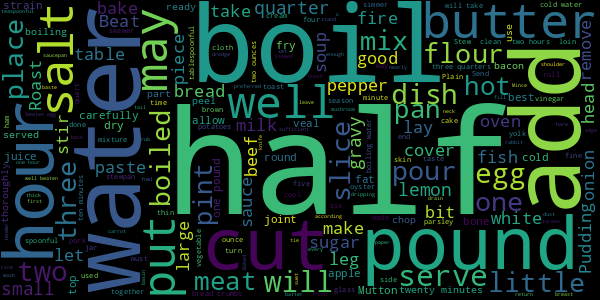

In [9]:
# First we make the wordcloud
# See how we feed the text variable into the generate function?
wc = WordCloud(width=600, height=300).generate(text)

# Display the wordcloud
wc.to_image()

You might notice that the wordcloud includes some two word phrases (called bigrams) such as 'an hour'. That's the packages default setting, but we can exclude them by setting `collocations=False`.

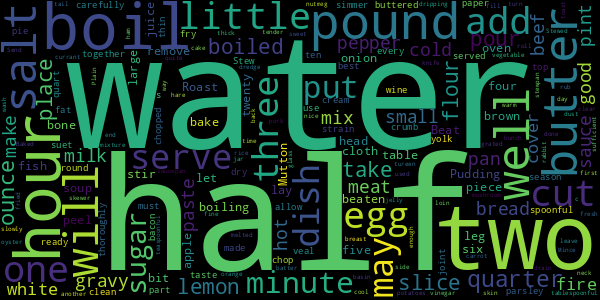

In [10]:
wc = WordCloud(width=600, height=300, collocations=False).generate(text)

# Display the wordcloud
wc.to_image()

## Word and n-gram frequencies

To go further in analysing texts, you'll probably want to use a specialised package. There's NLTK, Spacey, and many others. Here we'll use TextBlob, which is probably the simplest to use and understand.

Finding word frequencies with TextBlob is as simple as accessing `blob.word_counts`. However, we probably want to do a bit of filtering to remove some of the noise introduced by OCR. As before, we can also remove common stop words like 'a', 'the', and 'and'.

The cell below only keeps words that are longer than two characters (`len(w) > 2`), contain only alphabetical characters (`re.match(r'^[a-zA-Z \-]*$', w)`) and are not in the standard list of stop words.

Once we have our list of words/frequencies we'll use `Counter` to get the 10 most common words.

In [11]:
# First we load our text into TextBlob
blob = TextBlob(text)

In [12]:
# The we get the word counts, filter them, and display the most common
words = {w: c for w, c in dict(blob.word_counts).items() if len(w) > 2 and re.match(r'^[a-zA-Z \-]*$', w) and w not in stop_words}
Counter(words).most_common(10)

[('water', 352),
 ('half', 343),
 ('two', 309),
 ('boil', 292),
 ('butter', 272),
 ('pound', 244),
 ('little', 243),
 ('salt', 242),
 ('add', 239),
 ('well', 226)]

If you compare this list with the one above, you'll see they're very similar, but not eaxctly the same. Why? Most likely it's because of differences in the way words are extracted from the text. Above we used a very simple regular expression to identify words, but TextBlob uses a [more sophisticated](https://textblob.readthedocs.io/en/dev/_modules/textblob/tokenizers.html) set of rules.

TextBlob will also break our text up into multiple word phrases – *n*-grams, where 'n' represents the number of words. We saw some bigrams in the wordcloud above, but let's find more. To get a list of bigrams we just use `blob.ngrams(2)`. We can then use `Counter` to find the most common.

In [13]:
blob.ngrams(2)[:10]

[WordList(['w', 'jto']),
 WordList(['jto', 'V']),
 WordList(['V', 'i']),
 WordList(['i', 'S']),
 WordList(['S', 'to']),
 WordList(['to', '1']),
 WordList(['1', 'CHAMBERS']),
 WordList(['CHAMBERS', 'SEYMOUR']),
 WordList(['SEYMOUR', 'Iroriiiio-nger']),
 WordList(['Iroriiiio-nger', 'CORNER'])]

We can then join the separate parts of the ngram together (using `.join`) and use Counter to find the most common phrases.

In [14]:
Counter([' '.join(l) for l in blob.ngrams(2)]).most_common(10)

[('in a', 327),
 ('and a', 284),
 ('of the', 276),
 ('with a', 269),
 ('in the', 256),
 ('a little', 213),
 ('pound of', 190),
 ('of a', 188),
 ('an hour', 166),
 ('to the', 152)]

We can try trigrams as well!

In [15]:
Counter([' '.join(l) for l in blob.ngrams(3)]).most_common(10)

[('a pound of', 123),
 ('a pint of', 94),
 ('and a half', 90),
 ('a quarter of', 88),
 ('pepper and salt', 70),
 ('of a pound', 67),
 ('quarter of a', 59),
 ('a bit of', 56),
 ('half an hour', 52),
 ('one pound of', 51)]

The most common trigrams seem to relate to quantities – not so surprising in a recipe book! Let's focus in on this by looking at 4-grams (4 word phrases) that start with some of the common trigrams.

In [16]:
Counter([' '.join(l) for l in blob.ngrams(4) if ' '.join(l).startswith('a pound of')]).most_common(10)

[('a pound of butter', 17),
 ('a pound of sugar', 13),
 ('a pound of flour', 12),
 ('a pound of sifted', 6),
 ('a pound of beef', 4),
 ('a pound of bread', 4),
 ('a pound of pounded', 4),
 ('a pound of lean', 3),
 ('a pound of chopped', 3),
 ('a pound of loaf', 3)]

In [17]:
Counter([' '.join(l) for l in blob.ngrams(4) if ' '.join(l).startswith('a pint of')]).most_common(10)

[('a pint of water', 21),
 ('a pint of milk', 16),
 ('a pint of good', 10),
 ('a pint of boiling', 6),
 ('a pint of new', 4),
 ('a pint of vinegar', 4),
 ('a pint of cream', 4),
 ('a pint of melted', 2),
 ('a pint of hot', 2),
 ('a pint of white', 2)]

In [18]:
Counter([' '.join(l) for l in blob.ngrams(4) if ' '.join(l).startswith('a tablespoonful of')]).most_common(10)

[('a tablespoonful of flour', 2),
 ('a tablespoonful of curry', 2),
 ('a tablespoonful of vinegar', 1),
 ('a tablespoonful of ketchup', 1),
 ('a tablespoonful of any', 1),
 ('a tablespoonful of walnut', 1),
 ('a tablespoonful of Harvey', 1),
 ('a tablespoonful of chopped', 1),
 ('a tablespoonful of cream', 1),
 ('a tablespoonful of mushroom', 1)]

<div class="alert alert-info">A challenge! Using the examples above, can you find the 10 most common 4-grams? What about 5-grams?</div>

## What's next

You can also use TextBlob to extract more complex structures such as parts of speech. For an example, see the [Recipe Generator](recipe-generator.ipynb)!

----

Created by [Tim Sherratt](https://timsherratt.org) for the [GLAM Workbench](https://glam-workbench.github.io/).